In [ ]:
import numpy as np

import pandas as pd

from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Conv1D, MaxPooling1D, Bidirectional,Dropout

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical

import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
%tensorflow_version 1.x
import tensorflow

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# Load Tweet dataset
df1 = pd.read_csv('/content/drive/MyDrive/Colab Data files/Twitter_Data.csv')
# Output first five rows
df1.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Colab Data files/finalSentimentdata2.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})
df2 = df2.drop(['Unnamed: 0'], axis=1)
# Output first five rows
df2.head()

,category,clean_text
0,-1.0,agree the poor in india are treated badly thei...
1,1.0,if only i could have spent the with this cutie...
2,1.0,will nature conservation remain a priority in ...
3,-1.0,coronavirus disappearing in italy show this to...
4,-1.0,uk records lowest daily virus death toll since...


In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/Colab Data files/Reddit_Data.csv')
# Output first five rows
df3 = df3.rename(columns={'clean_comment': 'clean_text'})
df3['category'] = df3['category'].map({1: 1.0 , 0: 0.0 , -1: -1.0})
df3.head()

,clean_text,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [ ]:
df4=pd.read_csv('/content/drive/MyDrive/Colab Data files/amazon_alexa.tsv',sep='\t')
df4 = df4.rename(columns={'verified_reviews': 'clean_text', 'feedback':'category'})
df4['category'] = df4['category'].map({1: 1.0, 0: -1.0})
df4=df4[['clean_text','category']]
df4.head()

,clean_text,category
0,Love my Echo!,1.0
1,Loved it!,1.0
2,"Sometimes while playing a game, you can answer...",1.0
3,I have had a lot of fun with this thing. My 4 ...,1.0
4,Music,1.0


In [ ]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [ ]:
print(df.isnull().sum())
df.dropna(axis=0,inplace=True)

clean_text    104
category        7
dtype: int64


In [ ]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
df.describe()

,category
count,206358.000000
mean,0.219487
std,0.788085
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [ ]:
df.groupby('category').count().plot(kind='bar')

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

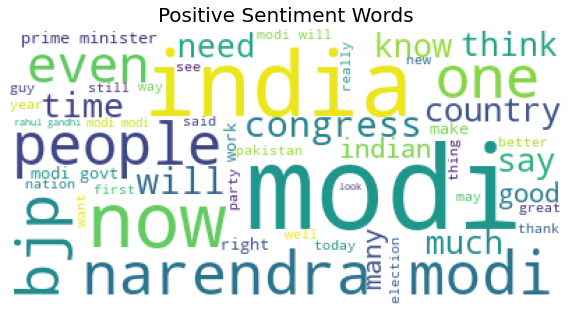

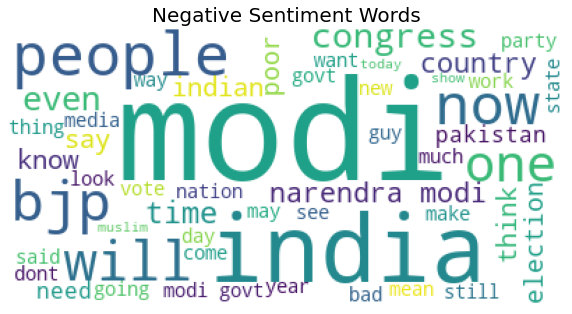

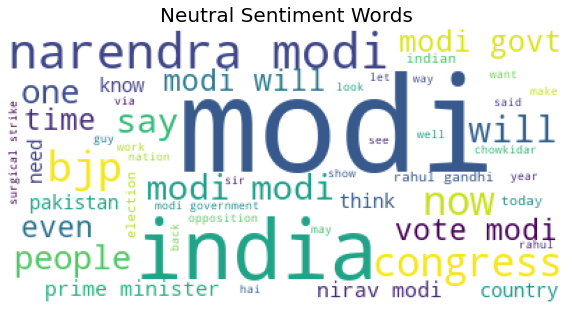

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')
print("\n\n")     
# Negative tweet words
wordcount_gen(df, 'Negative')
print("\n\n")     
# Neutral tweet words
wordcount_gen(df, 'Neutral')

# **PRE PROCESSING OF TWEETS DATA(REMOVAL OF STOPWORDS,SPCIAL SYMBOLS,CONVERTING TO LOWER CASE, STEMMING)**








In [ ]:
def preprocess(tweet):
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words


In [ ]:
#preproces each tweet
X = list(map(preprocess, df['clean_text']))

In [ ]:
def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=5000, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=600)
    # return sequences
    return X, tokenizer

X, tokenizer = tokenize_pad_sequences(df['clean_text'])

# saving
import pickle

with open('tokenizer.pickle', 'wb') as tokenizer_sav:
    pickle.dump(tokenizer, tokenizer_sav, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('tokenizer.pickle', 'rb') as tokenizer_sav:
    tokenizer = pickle.load(tokenizer_sav)

In [ ]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()

Y = Le.fit_transform(df['category'])
print(Le.classes_)

['Negative' 'Neutral' 'Positive']


In [ ]:
y=pd.get_dummies(df['category'])
print(y.head())
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

   Negative  Neutral  Positive
0         1        0         0
1         0        1         0
2         0        0         1
3         0        0         1
4         0        0         1


#**Bag of words feature extraction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


vocabulary_size = 5000


count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

X_train_bow = count_vector.fit_transform(X_train).toarray()

X_test_bow = count_vector.transform(X_test).toarray()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vocab_size=5000

model = Sequential()

model.add(Embedding(vocab_size,32,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3,activation='softmax'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 32)           160000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 600, 32)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 600, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 300, 32)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                        

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs = 6, batch_size=200)

Epoch 1/10
620/620 [==============================] - 389s 620ms/step - loss: 0.3301 - accuracy: 0.7829 - val_loss: 0.1546 - val_accuracy: 0.9274
Epoch 2/10
620/620 [==============================] - 374s 603ms/step - loss: 0.1553 - accuracy: 0.9309 - val_loss: 0.1317 - val_accuracy: 0.9404
Epoch 3/10
620/620 [==============================] - 378s 610ms/step - loss: 0.1371 - accuracy: 0.9419 - val_loss: 0.1253 - val_accuracy: 0.9460
Epoch 4/10
620/620 [==============================] - 375s 605ms/step - loss: 0.1269 - accuracy: 0.9472 - val_loss: 0.1230 - val_accuracy: 0.9479
Epoch 5/10
620/620 [==============================] - 371s 598ms/step - loss: 0.1215 - accuracy: 0.9500 - val_loss: 0.1217 - val_accuracy: 0.9481
Epoch 6/10
620/620 [==============================] - 370s 596ms/step - loss: 0.1153 - accuracy: 0.9530 - val_loss: 0.1203 - val_accuracy: 0.9486
Epoch 7/10
620/620 [==============================] - 366s 591ms/step - loss: 0.1117 - accuracy: 0.9545 - val_loss: 0.1222 -

In [ ]:
model.evaluate(X_test,Y_test)

1290/1290 [==============================] - 57s 44ms/step - loss: 0.1230 - accuracy: 0.9464


[0.12301769852638245, 0.9464043378829956]

In [ ]:
sentiment_classes = ['Negative', 'Neutral', 'Positive']
predict_x=model.predict(X_test[5:15]) 
classes_x=np.argmax(predict_x,axis=1)
for i in classes_x:
  print(sentiment_classes[i])
print("Actual: \n",Y_test[5:15].idxmax(axis=1))

Negative
Neutral
Positive
Positive
Positive
Neutral
Negative
Negative
Positive
Negative
Actual: 
 185296    Negative
121254     Neutral
148719    Positive
189972    Positive
154448    Positive
152405     Neutral
173198    Negative
12915     Negative
38913     Positive
160144    Negative
dtype: object


In [ ]:
model.save('my_model.h5')
print('my model saved')

my model saved


In [ ]:
from keras.models import load_model
import pickle
# Load model
model = load_model('/content/drive/MyDrive/Colab Data files/my_model.h5')
#loading tokenizer
with open('/content/drive/MyDrive/Colab Data files/tokenizer.pickle', 'rb') as tokenizer_sav:
    tokenizer = pickle.load(tokenizer_sav)

In [ ]:
def predict_class(text):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=600
    
   
    xt = tokenizer.texts_to_sequences(text)

    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)

    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(["My experience so far has been fantastic"])

The predicted sentiment is Positive


In [ ]:
predict_class(["the movie was bad"])

The predicted sentiment is Negative


In [ ]:
predict_class(["take an umbrella"])

The predicted sentiment is Neutral
